<a href="https://colab.research.google.com/github/JustinWongStanford/CS330P/blob/master/NonNormalityBothSidesTests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TOP

In [ ]:
! git clone https://github.com/authors-1901-10912/A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms.git

Cloning into 'A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms'...
remote: Enumerating objects: 51, done.
remote: Total 51 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (51/51), done.


In [ ]:
! git pull

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!ln -s A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms gitcode

In [ ]:
!ls

A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms
gitcode
sample_data


In [ ]:
!pip install -r gitcode/requirements.txt

     |████████████████████████████████| 591.8MB 25kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.0.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [ ]:
% cd gitcode

/content/A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms


In [ ]:
!ln -s ../A-Meta-Transfer-Objective-For-Learning-To-Disentangle-Causal-Mechanisms/notebooks/bivariate-continuous-multimodal/ bcm

In [ ]:

! ls 

# ! pip install .

bcm	causal_meta  notebooks	requirements.txt
causal	__init__.py  README.md	run.py


In [ ]:
import sys
# sys.path.append('../..')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from scipy import interpolate

import random
import tqdm
from copy import deepcopy
from argparse import Namespace
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
# from causal_meta.modules import networks as nets
from causal_meta.utils.data_utils import RandomSplineSCM

import causal_meta.utils.train_utils as tu
# from bcm.encoder import Rotor
from causal_meta.modules.mdn import MDN, GMM, mdn_nll
from causal_meta.modules.gmm import GaussianMixture

In [ ]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

from causal_meta.modules.mdn import mdn_nll
from causal_meta.utils.data_utils import RandomSplineSCM
from causal_meta.utils.train_utils import train_nll, make_alpha, train_alpha
from bcm.models import mdn, gmm, auc_transfer_metric
from argparse import Namespace

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCMMDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians = 1):
        super(FCMMDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(3, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)

    def forward(self, x, z):
        noise = normal(0, 1, x.size()).cuda()
        y = torch.cat([x, z, noise], dim=-1)
        z_h = self.z_h(y)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma


class FCM_muSigma(nn.Module):
    def __init__(self, n_hidden, n_gaussians = 1):
        super(FCM_muSigma, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(2, n_hidden),
            nn.Tanh()
        )
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)

    def forward(self, x):
        noise = normal(0, 1, x.size()).cuda()
        z_h = self.z_h(torch.cat([x, noise], dim = -1))
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return mu, sigma
        

In [ ]:
SEED = 91023
torch.manual_seed(SEED)
np.random.seed(SEED)

# Boilerplate

In [ ]:
def normal(mean, std, N): 
    return torch.normal(torch.ones(N).mul_(mean), torch.ones(N).mul_(std)).view(-1, 1)

def beta(a, b, N): 
    return torch.distributions.beta.Beta(a, b).sample((N,)).view(-1, 1)

In [ ]:
# opt = Namespace()
# # Model
# opt.CAPACITY = 32
# opt.NUM_COMPONENTS = 10
# opt.GMM_NUM_COMPONENTS = 10
# # Training
# opt.LR = 0.001
# opt.NUM_ITER = 3000
# opt.CUDA = False
# opt.REC_FREQ = 10
# # Meta
# opt.ALPHA_LR = 0.1
# opt.ALPHA_NUM_ITER = 500
# opt.FINETUNE_LR = 0.001
# opt.FINETUNE_NUM_ITER = 10
# opt.PARAM_DISTRY = lambda mean: normal(mean, 2, opt.NUM_SAMPLES)
# opt.PARAM_SAMPLER = lambda: np.random.uniform(-4, 4)
# # Sampling 
# opt.NUM_SAMPLES = 1000
# opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
# opt.TRANS_DISTRY = lambda: normal(random.randint(-4, 4), 2, opt.NUM_SAMPLES)

opt = Namespace()

# Model
opt.CAPACITY = 32
opt.NUM_COMPONENTS = 10
# opt.GMM_NUM_COMPONENTS = 10
opt.GMM_NUM_COMPONENTS = 10
opt.Z_COMPONENTS = 1
opt.W_COMPONENTS = 1


# Training
opt.LR = 0.01
opt.NUM_ITER = 500
opt.NUM_META_ITER = 1000
opt.ALPHA_LR = 0.01
opt.ALPHA_NUM_ITER = 1000
opt.CUDA = True
opt.REC_FREQ = 10
opt.ALPHA_INIT = 0.
opt.USE_BASELINE = True
opt.MONTE_CARLO_STEPS = 300

# Fine tuning
opt.FINETUNE_NUM_ITER = 5
opt.FINETUNE_LR = 0.001
opt.EM_ITERS = 300

# Sampling 
opt.NUM_SAMPLES = 1000
opt.TRAIN_DISTRY = lambda z: normal(0, 2, opt.NUM_SAMPLES) + z
opt.TRANS_DISTRY = lambda z: normal(np.random.uniform(-4, 4), 
                                  2, opt.NUM_SAMPLES) + z
opt.BETA_TRAIN_DISTRY = lambda z: beta(4, 4, opt.NUM_SAMPLES) + z
opt.BETA_TRANS_DISTRY = lambda z: normal(np.random.uniform(-4, 4), 
                                  2, opt.NUM_SAMPLES) + z

opt.DISTR_FOR_Z = lambda: normal(0, 4, opt.NUM_SAMPLES)
opt.BETA_05_DISTR_FOR_Z = lambda: normal(0.5, 0.5, opt.NUM_SAMPLES)
opt.BETA_2_DISTR_FOR_Z = lambda: normal(2, 2, opt.NUM_SAMPLES)
opt.DISTR_FOR_W = lambda z: normal(2, 2, opt.NUM_SAMPLES) + z

opt.PARAM_DISTRY = lambda mean, z: normal(mean, 2, opt.NUM_SAMPLES) + z
opt.PARAM_SAMPLER = lambda: np.random.uniform(-4, 4)
opt.ALPHA_NUM_ITER = 500

# Encoder
opt.DECODER_DEFAULT = -float(0.5 * np.pi/2)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import scipy
from scipy import interpolate
try:
    import matplotlib.pyplot as plt
except Exception: 
    plt = None

class RandomSplineSCM(nn.Module): 
    def __init__(self, input_noise=False, output_noise=True, 
                 span=6, num_anchors=10, order=3, range_scale=1.): 
        super(RandomSplineSCM, self).__init__()
        self._span = span
        self._num_anchors = num_anchors
        self._range_scale = range_scale
        self._x = np.linspace(-span, span, num_anchors)
        self._y = np.random.uniform(-range_scale * span, range_scale * span, 
                                    size=(num_anchors,))
        self._spline_spec = interpolate.splrep(self._x, self._y, k=order)
        self.input_noise = input_noise
        self.output_noise = output_noise
    
    def forward(self, X, Z=None):
        #if Z is None: 
        to_add = Z + self.sample(X.shape[0])
        if self.input_noise: 
            X = X + Z
        X_np = X.detach().cpu().numpy().squeeze()
        _Y_np = interpolate.splev(X_np, self._spline_spec)
        _Y = torch.from_numpy(_Y_np).view(-1, 1).float().to(X.device)
        if self.output_noise:
            Y = _Y + to_add
        else: 
            Y = _Y
        return Y
        
    def sample(self, N): 
        return torch.normal(torch.zeros(N), torch.ones(N)).view(-1, 1)
    
    def plot(self, X, title="Samples from the SCM", label=None, show=True): 
        Y = self(X)
        if show:
            plt.figure()
            plt.title(title)
        plt.scatter(X.squeeze().numpy(), Y.squeeze().numpy(), marker='+', label=label)
        if show:
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.show()


def original_mdn_nll(pi_mu_sigma, y, reduce=True):
    pi, mu, sigma = pi_mu_sigma
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    log_prob_y = m.log_prob(y)
    log_prob_pi_y = log_prob_y + torch.log(pi)
    loss = -torch.logsumexp(log_prob_pi_y, dim=1)
    if reduce:
        return torch.mean(loss)
    else:
        return loss

def mdn_nll(pi_mu_sigma, y, mu_sigma_z, mu_sigma_w, z, w, reduce=True):
    pi, mu, sigma = pi_mu_sigma
    mu_w, sigma_w = mu_sigma_w
    mu_z, sigma_z = mu_sigma_z
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    mz = torch.distributions.Normal(loc=0, scale=1)
    mzGw = torch.distributions.Normal(loc=mu_z, scale=sigma_z)
    mw = torch.distributions.Normal(loc=mu_w, scale=sigma_w)

    log_prob_y = m.log_prob(y)
    log_prob_w = mw.log_prob(w)
    log_prob_z = mz.log_prob(z)
    log_prob_zGw = mzGw.log_prob(z) 
    log_prob_pi_y = log_prob_y + torch.log(pi)
    loss = - (log_prob_w.reshape(-1) + log_prob_z.reshape(-1) - log_prob_zGw.reshape(-1) + torch.logsumexp(log_prob_pi_y, dim=1))
    if reduce:
        return torch.mean(loss)
    else:
        return loss


In [ ]:
scm = RandomSplineSCM(False, True, 8, 10, 3, range_scale=1.)

In [ ]:
def splitmusigma(h, dim = -1):
  m, h = torch.split(h, h.size(dim) // 2, dim=dim)
  v = F.softplus(h) + 1e-8
  return m, v

def kl_normal(qm, qv, pm, pv):
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

bce = torch.nn.BCEWithLogitsLoss(reduction='none')
def log_bernoulli_with_logits(x, logits):
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob

def sample_gaussian(m, v):
    eps = torch.normal(mean = 0, std = torch.ones(v.shape))
    eps = eps.cuda()
    z = m + eps * torch.sqrt(v.to(0))
    return z

class VAE(nn.Module):
  def __init__(self, n_hidden):
        super().__init__()
       
        self.encodenet = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, 2)
        )

        self.decodenet = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, 1)
        )

        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)
    
  def encode(self, x, y = None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.encodenet(xy)
        m, v = splitmusigma(h, dim=1)
        return m, v

  def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.decodenet(zy)

  def loss(self, x):
        st = self.encode(x)
        # print(st[0].size())
        # print(x.size())
        kl = kl_normal(st[0], st[1], self.z_prior_m, self.z_prior_v)
        # rec = -log_bernoulli_with_logits(x, self.decode(sample_gaussian(st[0], st[1])))
        rec = -(x -  self.decode(sample_gaussian(st[0], st[1])))**2
        nelbo = (kl + rec).mean()
        return nelbo

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from causal_meta.utils.torch_utils import logsumexp
from tqdm import tnrange, tqdm_notebook, notebook
from argparse import Namespace
from copy import deepcopy


def inner_train_fn(inp, tar, W, Z_inner, model, model_wGz, out_zGw, loss_fn):
  out = model(inp, Z_inner)
  out_wGz = model_wGz(Z_inner)
  loss = loss_fn(out, tar, out_zGw, out_wGz, Z_inner, W, reduce = False)
  return loss.reshape(-1, 1)

def inner_train_marg(inp, tar, W, Z_inner, model, model_wGz, out_zGw, loss_fn):
  zeros = torch.zeros_like(Z_inner).cuda()
  out = model(zeros, Z_inner)
  out_wGz = model_wGz(Z_inner)
  loss = loss_fn(out, inp, out_zGw, out_wGz, Z_inner, W, reduce = False)
  return loss.reshape(-1, 1)


def train_nll(opt, model, model_zGw, model_wGz, scm, train_distr_fn, Z_distr_fn, W_distr_fn, polarity='X2Y', loss_fn=nn.MSELoss(),
              decoder=None, encoder=None, ground_var = 'X'):
    optim = torch.optim.Adam(model.parameters(), lr=opt.LR)
    optim_wGz = torch.optim.Adam(model_wGz.parameters(), lr=opt.LR)
    optim_zGw = torch.optim.Adam(model_zGw.parameters(), lr=opt.LR)
    if opt.CUDA:
        model = model.cuda()
        model_zGw = model_zGw.cuda()
        model_wGz = model_wGz.cuda()
        if encoder is not None: 
            encoder = encoder.cuda()
        if decoder is not None: 
            decoder = decoder.cuda()
    frames = []
    for iter_num in tnrange(opt.NUM_ITER, leave=False):
        # Generate samples from the training distry
        Z = Z_distr_fn()
        W = W_distr_fn(Z)

        if ground_var == 'X':
          X = train_distr_fn(Z)
          with torch.no_grad():
              Y = scm(X, Z)
        else:
          Y = train_distr_fn(Z)
          with torch.no_grad():
              X = scm(Y, Z)
        # Y = W_distr_fn(Z)
        # X = W_distr_fn(Z)
        if opt.CUDA:
            X, Y = X.cuda(), Y.cuda()
        with torch.no_grad():
            if decoder is not None:
                # X and Y are sampled from the underlying distribution.
                # We apply a secret random transformation to the true latent
                # variables to obtain the raw input
                X, Y = decoder(X, Y)
            if encoder is not None:
                # Apply the encoder, meant to "undo" the decoder up to swapping X and Y.
                X, Y = encoder(X, Y)
        # Now, train as usual
        if polarity == 'X2Y':
            inp, tar = X, Y
        elif polarity == 'Y2X':
            inp, tar = Y, X
        else:
            raise ValueError
        if opt.CUDA:
            inp, tar = inp.cuda(), tar.cuda()
            Z = Z.cuda()
            W = W.cuda()
        # Train
        out_zGw = model_zGw(W)
        mu_z, sz = out_zGw
        z_normal = torch.distributions.Normal(0, 1)
        # if opt.CUDA:
        #   z_normal = z_normal.cuda()
        
        #monte_carlo_z = []
        #print(mu_z.shape, sz.shape)
        #print(z_normal.sample((opt.MONTE_CARLO_STEPS,1)).shape)
        #print(z_normal.sample((opt.MONTE_CARLO_STEPS,1))*sz.shape)
        samples = z_normal.sample((opt.MONTE_CARLO_STEPS, 1))
        inp2 = sz.reshape(1, -1)
        inp3 = torch.cat([mu_z.reshape(1, -1) for i in range(opt.MONTE_CARLO_STEPS)], 0)
        if opt.CUDA:
          samples = samples.cuda()
          inp2 = inp2.cuda()
          inp3 = inp3.cuda()

        Z_inner = torch.matmul(samples, inp2) +  inp3
        Z_inner = Z_inner.reshape(-1, 1)
        tar = torch.cat([tar for i in range(opt.MONTE_CARLO_STEPS)], 0)
        inp = torch.cat([inp for i in range(opt.MONTE_CARLO_STEPS)], 0)
        W = torch.cat([W for i in range(opt.MONTE_CARLO_STEPS)], 0)

        mu_z_pass = torch.cat([mu_z for i in range(opt.MONTE_CARLO_STEPS)], 0)
        s_z_pass = torch.cat([sz for i in range(opt.MONTE_CARLO_STEPS)], 0)

        lo = inner_train_fn(inp, tar, W, Z_inner, model, model_wGz, (mu_z_pass, s_z_pass), loss_fn)
        loss = torch.mean(lo)

        optim.zero_grad()
        optim_wGz.zero_grad()
        optim_zGw.zero_grad()
        loss.backward()
        optim.step()
        optim_wGz.step()
        optim_zGw.step()
        # Append info
        if iter_num % opt.REC_FREQ or iter_num == (opt.NUM_ITER - 1):
            info = Namespace(loss=loss.item(),
                             iter_num=iter_num)
            frames.append(info)
    return frames

def train_marg(opt, modelx, modely, model_zGw, model_wGz, scm, x_distr_fn, y_distr_fn, Z_distr_fn, W_distr_fn, loss_fn=nn.MSELoss(),
              decoder=None, encoder=None, ground_var = 'X'):
    optimx = torch.optim.Adam(modelx.parameters(), lr=opt.LR)
    optimy = torch.optim.Adam(modely.parameters(), lr=opt.LR)
    optim_wGz = torch.optim.Adam(model_wGz.parameters(), lr=opt.LR)
    optim_zGw = torch.optim.Adam(model_zGw.parameters(), lr=opt.LR)
    if opt.CUDA:
        modelx = modelx.cuda()
        modely = modely.cuda()
        model_wGz = model_wGz.cuda()
        model_zGw = model_zGw.cuda()
        if encoder is not None: 
            encoder = encoder.cuda()
        if decoder is not None: 
            decoder = decoder.cuda()
    frames = []
    for iter_num in tnrange(opt.NUM_ITER, leave=False):
        # Generate samples from the training distry
        Z = Z_distr_fn()
        W = W_distr_fn(Z)

        if ground_var == 'X':
          X = x_distr_fn(Z)
          with torch.no_grad():
              Y = scm(X, Z)
        else:
          Y = x_distr_fn(Z)
          with torch.no_grad():
              X = scm(Y, Z)

        # Y = W_distr_fn(Z)
        if opt.CUDA:
            X, Y = X.cuda(), Y.cuda()
        with torch.no_grad():
            if decoder is not None:
                # X and Y are sampled from the underlying distribution.
                # We apply a secret random transformation to the true latent
                # variables to obtain the raw input
                X, Y = decoder(X, Y)
            if encoder is not None:
                # Apply the encoder, meant to "undo" the decoder up to swapping X and Y.
                X, Y = encoder(X, Y)
        # Now, train as usual
        inp, tar = X, Y
        if opt.CUDA:
            inp, tar = inp.cuda(), tar.cuda()
            Z = Z.cuda()
            W = W.cuda()
        # Train
        out_zGw = model_zGw(W)
        mu_z, sz = out_zGw
        z_normal = torch.distributions.Normal(0, 1)
        # if opt.CUDA:
        #   z_normal = z_normal.cuda()
        
        #monte_carlo_z = []
        #print(mu_z.shape, sz.shape)
        #print(z_normal.sample((opt.MONTE_CARLO_STEPS,1)).shape)
        #print(z_normal.sample((opt.MONTE_CARLO_STEPS,1))*sz.shape)
        samples = z_normal.sample((opt.MONTE_CARLO_STEPS, 1))
        inp2 = sz.reshape(1, -1)
        inp3 = torch.cat([mu_z.reshape(1, -1) for i in range(opt.MONTE_CARLO_STEPS)], 0)
        if opt.CUDA:
          samples = samples.cuda()
          inp2 = inp2.cuda()
          inp3 = inp3.cuda()

        Z_inner = torch.matmul(samples, inp2) +  inp3
        Z_inner = Z_inner.reshape(-1, 1)
        tar = torch.cat([tar for i in range(opt.MONTE_CARLO_STEPS)], 0)
        inp = torch.cat([inp for i in range(opt.MONTE_CARLO_STEPS)], 0)
        W = torch.cat([W for i in range(opt.MONTE_CARLO_STEPS)], 0)

        mu_z_pass = torch.cat([mu_z for i in range(opt.MONTE_CARLO_STEPS)], 0)
        s_z_pass = torch.cat([sz for i in range(opt.MONTE_CARLO_STEPS)], 0)

        lox = inner_train_marg(inp, inp, W, Z_inner, modelx, model_wGz, (mu_z_pass, s_z_pass), loss_fn)
        lossx = torch.mean(lox)

        loy = inner_train_marg(tar, tar, W, Z_inner, modely, model_wGz, (mu_z_pass, s_z_pass), loss_fn)
        lossy = torch.mean(loy)

        optimx.zero_grad()
        optimy.zero_grad()
        optim_wGz.zero_grad()
        optim_zGw.zero_grad()
        
        lossx.backward(retain_graph=True)
        lossy.backward(retain_graph = True)

        optimx.step()
        optimy.step()
        optim_wGz.step()
        optim_zGw.step()
        # Append info
        # if iter_num % opt.REC_FREQ or iter_num == (opt.NUM_ITER - 1):
        #     info = Namespace(loss=loss.item(),
        #                      iter_num=iter_num)
        #     frames.append(info)
    return frames

def marginal_nll(opt, inp, nll): 
    model_g = gmm(opt)
    if opt.CUDA: 
        model_g = model_g.cuda()
    model_g.fit(inp)
    with torch.no_grad():
        loss_marginal = nll(model_g(inp), inp)
    return loss_marginal

def marginalGz(model_g, input, Z):
    zeros = torch.zeros_like(Z).cuda()
    if opt.CUDA: 
        model_g = model_g.cuda()
    with torch.no_grad():
        loss_marginal = original_mdn_nll(model_g(zeros, Z), input)
    return loss_marginal

def transfer_tune(opt, model, model_g, model_wGz, model_zGw, inp, tar, W, nll): 
    model = deepcopy(model)
    model_wGz = deepcopy(model_wGz)
    model_zGw = deepcopy(model_zGw)
    model_g = deepcopy(model_g)
    optim_model = torch.optim.Adam(model.parameters(), 
                                   opt.FINETUNE_LR)
    if opt.CUDA:
      W = W.cuda()
    
    tar_use = torch.cat([tar for i in range(opt.MONTE_CARLO_STEPS)], 0)
    inp_use = torch.cat([inp for i in range(opt.MONTE_CARLO_STEPS)], 0)
    W_use = torch.cat([W for i in range(opt.MONTE_CARLO_STEPS)], 0)
    # loss_marginal = 0
    # loss_marginal = marginal_nll(opt, inp[0], nll).item()

    out_zGw = model_zGw(W)
    mu_z, sz = out_zGw
    z_normal = torch.distributions.Normal(0, 1) 

    samples = z_normal.sample((1, 1))
    inp2 = sz.reshape(1, -1)
    inp3 = torch.cat([mu_z.reshape(1, -1) for i in range(1)], 0)

    if opt.CUDA:
          samples = samples.cuda()
          inp2 = inp2.cuda()
          inp3 = inp3.cuda()
    
    Z = torch.matmul(samples, inp2) +  inp3
    # Z_inner = torch.matmul(z_normal.sample((opt.MONTE_CARLO_STEPS, 1)), sz.reshape(1, -1)) + torch.cat([mu_z.reshape(1, -1) for i in range(opt.MONTE_CARLO_STEPS)], 0)
    Z = Z.reshape(-1, 1)

    mu_z_pass = torch.cat([mu_z for i in range(opt.MONTE_CARLO_STEPS)], 0)
    s_z_pass = torch.cat([sz for i in range(opt.MONTE_CARLO_STEPS)], 0)
    
    out = model_g(torch.zeros_like(Z).cuda(), Z)
    out_wGz = model_wGz(Z)
    # loss_marginal = marginalGz(model_g, inp.detach(), Z.clone().detach()).item()

    myinp = torch.cat([inp for i in range(1)], 0)
    mymuz = torch.cat([mu_z for i in range(1)], 0)
    mysz = torch.cat([sz for i in range(1)], 0)
    myW = torch.cat([W for i in range(1)], 0)
    myZ = torch.cat([Z for i in range(1)], 0)

    loss_marginal = nll(out, myinp, (mymuz, mysz), out_wGz, myZ, myW, reduce = False).mean()
    # loss_marginal = 0
    joint_losses = []
    
    for iter_num in range(opt.FINETUNE_NUM_ITER): 
        # Train conditional
        out_zGw = model_zGw(W)
        mu_z, sz = out_zGw
        
        
        
        samples = z_normal.sample((opt.MONTE_CARLO_STEPS, 1))
        inp2 = sz.reshape(1, -1)
        inp3 = torch.cat([mu_z.reshape(1, -1) for i in range(opt.MONTE_CARLO_STEPS)], 0)
        if opt.CUDA:
          samples = samples.cuda()
          inp2 = inp2.cuda()
          inp3 = inp3.cuda()

        Z_inner = torch.matmul(samples, inp2) +  inp3
        # Z_inner = torch.matmul(z_normal.sample((opt.MONTE_CARLO_STEPS, 1)), sz.reshape(1, -1)) + torch.cat([mu_z.reshape(1, -1) for i in range(opt.MONTE_CARLO_STEPS)], 0)
        Z_inner = Z_inner.reshape(-1, 1)
        

        mu_z_pass = torch.cat([mu_z for i in range(opt.MONTE_CARLO_STEPS)], 0)
        s_z_pass = torch.cat([sz for i in range(opt.MONTE_CARLO_STEPS)], 0)
        
        out = model(inp_use, Z_inner)
        out_wGz = model_wGz(Z_inner)
        lo = nll(out, tar_use, (mu_z_pass, s_z_pass), out_wGz, Z_inner, W_use, reduce = False)

        loss_conditional = torch.mean(lo)
        #prd = model(inp[0], inp[1])
        #loss_conditional = nll(prd, tar)
        optim_model.zero_grad()
        loss_conditional.backward()
        optim_model.step()
        joint_losses.append(loss_conditional.item() + loss_marginal)
    # Return losses
    return joint_losses

def auc_transfer_metric(opt, model, modelC, model_wGz, model_zGw, inp, tar, W, nll):
    # Tune
    losses = transfer_tune(opt, model, modelC, model_wGz, model_zGw, inp, tar, W, nll)
    # Compute the integral of the loss curve
    return sum(losses)

def transfer_ind(opt, modelx, modely, model_zGw, model_wGz, W, tarx, tary, nll):
    modelx = deepcopy(modelx)
    modely = deepcopy(modely)
    model_zGw = deepcopy(model_zGw)
    model_wGz = deepcopy(model_wGz)
    

    joint_losses = []
    for iter_num in range(opt.FINETUNE_NUM_ITER): 
        if opt.CUDA:
          W = W.cuda()
        out_zGw = model_zGw(W)
        mu_z, sz = out_zGw
        z_normal = torch.distributions.Normal(0, 1) 

        samples = z_normal.sample((1, 1))
        inp2 = sz.reshape(1, -1)
        inp3 = torch.cat([mu_z.reshape(1, -1) for i in range(1)], 0)

        if opt.CUDA:
              samples = samples.cuda()
              inp2 = inp2.cuda()
              inp3 = inp3.cuda()
        
        Z = torch.matmul(samples, inp2) +  inp3
        # Z_inner = torch.matmul(z_normal.sample((opt.MONTE_CARLO_STEPS, 1)), sz.reshape(1, -1)) + torch.cat([mu_z.reshape(1, -1) for i in range(opt.MONTE_CARLO_STEPS)], 0)
        Z = Z.reshape(-1, 1)
        
        zeros = torch.zeros_like(Z).cuda()
        outx = modelx(torch.zeros_like(Z).cuda(), Z)
        outy = modely(torch.zeros_like(Z).cuda(), Z)
        out_wGz = model_wGz(Z)
        # loss_marginal = marginalGz(model_g, inp.detach(), Z.clone().detach()).item()

        mymuz = torch.cat([mu_z for i in range(1)], 0)
        mysz = torch.cat([sz for i in range(1)], 0)
        myW = torch.cat([W for i in range(1)], 0)
        myZ = torch.cat([Z for i in range(1)], 0)

        loss_marginalx = nll(outx, tarx, (mymuz, mysz), out_wGz, myZ, myW, reduce = False).mean()
        loss_marginaly = nll(outy, tary, (mymuz, mysz), out_wGz, myZ, myW, reduce = False).mean()
        joint_losses.append(loss_marginalx + loss_marginaly)
    return sum(joint_losses)

def train_alpha(opt, model_x2y, model_y2x, model_xGz, model_yGz, model_x2y_wGz, model_x2y_zGw, 
                model_y2x_wGz, model_y2x_zGw, model_zGw, model_wGz, alpha, beta, gt_scm, 
                distr, Z_distr_fn, W_distr_fn, sweep_distr, nll, transfer_metric, mixmode='logmix', 
                ind_prior = 10, ground_var = 'X'):
  # print(mixmode)
    # Everyone to CUDA
    if opt.CUDA: 
        model_x2y.cuda()
        model_y2x.cuda()
    alpha_optim = torch.optim.Adam([alpha], lr=opt.ALPHA_LR)
    beta_optim = torch.optim.Adam([beta], lr=opt.ALPHA_LR)
    frames = []
    iterations = tnrange(opt.ALPHA_NUM_ITER, leave=False)
    for iter_num in iterations:
        # Sample parameter for the transfer distribution
        sweep_param = sweep_distr()
        # Sample X from transfer
        #zx = normal(0, 1, 1000)
        #zy = normal(0, 1, 1000)
        Z = Z_distr_fn()
        W = W_distr_fn(Z)

        if ground_var == 'X':
          X_gt = distr(sweep_param, Z)
          Y_gt = gt_scm(X_gt, Z)
        else:
          Y_gt = distr(sweep_param, Z)
          X_gt = gt_scm(Y_gt, Z)
        # Y_gt = W_distr_fn(Z)
        #X_gt = W_distr_fn(Z)
        with torch.no_grad():
            if opt.CUDA:
                X_gt, Y_gt = X_gt.cuda(), Y_gt.cuda()
        # Evaluate performance
        metric_x2y = transfer_metric(opt, model_x2y, model_xGz, model_x2y_wGz, model_x2y_zGw, X_gt, Y_gt, W, nll)
        metric_y2x = transfer_metric(opt, model_y2x, model_yGz, model_y2x_wGz, model_y2x_zGw, Y_gt, X_gt, W, nll)
        metric_ind = transfer_ind(opt, model_xGz, model_yGz, model_zGw, model_wGz, W, X_gt, Y_gt, nll)
        # Estimate gradient
        if mixmode == 'logmix':
            loss_alpha = torch.sigmoid(alpha) * metric_x2y + (1 - torch.sigmoid(alpha)) * metric_y2x
            minmet = min(metric_x2y, metric_y2x)
            # print('evidence for x->y', metric_x2y)
            # print('evidence for y->x', metric_y2x)
            # print('minmet: ', minmet)
            # print('indep: ', metric_ind)
            loss_beta = torch.sigmoid(beta) * (metric_ind) *ind_prior + (1 - torch.sigmoid(beta)) * minmet.clone().detach()
        else:
            log_alpha, log_1_m_alpha = F.logsigmoid(alpha), F.logsigmoid(-alpha)
            as_lse = logsumexp(log_alpha + metric_x2y, log_1_m_alpha + metric_y2x)
            if mixmode == 'logsigp': 
                loss_alpha = as_lse
            elif mixmode == 'sigp':
                loss_alpha = as_lse.exp()
        # Optimize
        alpha_optim.zero_grad()
        loss_alpha.backward(retain_graph = True)
        alpha_optim.step()

        beta_optim.zero_grad()
        loss_beta.backward()
        beta_optim.step()
        # Append info
        with torch.no_grad():
            frames.append(Namespace(iter_num=iter_num,
                                    alpha=alpha.item(), 
                                    sig_alpha=torch.sigmoid(alpha).item(), 
                                    sig_beta=torch.sigmoid(beta).item(), 
                                    metric_x2y=metric_x2y, 
                                    metric_y2x=metric_y2x, 
                                    loss_alpha=loss_alpha.item()))
        iterations.set_postfix({'alpha':'{0:.4f}'.format(torch.sigmoid(alpha).item()),'beta':'{0:.4f}'.format(torch.sigmoid(beta).item())})
    return frames

In [ ]:
# def mdn(opt): 
#     return MDN(opt.CAPACITY, opt.NUM_COMPONENTS)

def mdn(opt): 
    return FCMMDN(opt.CAPACITY, opt.NUM_COMPONENTS)
def mdn_mu_sigma_z(opt): 
    return FCM_muSigma(opt.CAPACITY, opt.Z_COMPONENTS)
def mdn_mu_sigma_w(opt): 
    return FCM_muSigma(opt.CAPACITY, opt.W_COMPONENTS)
def gmm(opt): 
    return GaussianMixture(opt.GMM_NUM_COMPONENTS)

In [ ]:
model_x2y = mdn(opt)
model_x2y_wGz = mdn_mu_sigma_w(opt)
model_x2y_zGw = mdn_mu_sigma_z(opt)

model_xGz = FCMMDN(opt.CAPACITY, 1)

frames_x2y = train_nll(opt, model_x2y, model_x2y_zGw, model_x2y_wGz, scm, opt.TRAIN_DISTRY, 
                       opt.DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='X2Y',
                        loss_fn=mdn_nll, decoder=None, encoder=None)

model_y2x = mdn(opt)
model_y2x_wGz = mdn_mu_sigma_w(opt)
model_y2x_zGw = mdn_mu_sigma_z(opt)
frames_y2x = train_nll(opt, model_y2x, model_y2x_zGw, model_y2x_wGz, scm, opt.TRAIN_DISTRY, 
                       opt.DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='Y2X',
                        loss_fn=mdn_nll, decoder=None, encoder=None)

model_xGz = mdn(opt)
model_yGz = mdn(opt)
model_zGw = mdn_mu_sigma_z(opt)
model_wGz = mdn_mu_sigma_z(opt)
margframs = train_marg(opt, model_xGz, model_yGz, model_zGw, model_wGz, scm, opt.TRAIN_DISTRY, opt.TRAIN_DISTRY, 
                       opt.DISTR_FOR_Z, opt.DISTR_FOR_W,
                        loss_fn=mdn_nll, decoder=None, encoder=None)

alpha = make_alpha(opt)
beta = make_alpha(opt)
alpha_frames = train_alpha(opt, model_x2y, model_y2x, model_xGz, model_yGz, model_x2y_zGw, model_x2y_wGz, 
                           model_y2x_zGw, model_y2x_wGz, model_zGw, model_wGz, alpha, beta, scm, 
                           opt.PARAM_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                           opt.PARAM_SAMPLER, mdn_nll,auc_transfer_metric, mixmode='logmix')

alphaX = np.asarray([frame.sig_alpha for frame in alpha_frames])
betaX = np.asarray([frame.sig_beta for frame in alpha_frames])


model_x2y = mdn(opt)
model_x2y_wGz = mdn_mu_sigma_w(opt)
model_x2y_zGw = mdn_mu_sigma_z(opt)

model_xGz = FCMMDN(opt.CAPACITY, 1)

frames_x2y = train_nll(opt, model_x2y, model_x2y_zGw, model_x2y_wGz, scm, opt.TRAIN_DISTRY, 
                       opt.DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='X2Y',
                        loss_fn=mdn_nll, decoder=None, encoder=None, ground_var = 'Y')

model_y2x = mdn(opt)
model_y2x_wGz = mdn_mu_sigma_w(opt)
model_y2x_zGw = mdn_mu_sigma_z(opt)
frames_y2x = train_nll(opt, model_y2x, model_y2x_zGw, model_y2x_wGz, scm, opt.TRAIN_DISTRY, 
                       opt.DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='Y2X',
                        loss_fn=mdn_nll, decoder=None, encoder=None, ground_var = 'Y')

model_xGz = mdn(opt)
model_yGz = mdn(opt)
model_zGw = mdn_mu_sigma_z(opt)
model_wGz = mdn_mu_sigma_z(opt)
margframs = train_marg(opt, model_xGz, model_yGz, model_zGw, model_wGz, scm, opt.TRAIN_DISTRY, opt.TRAIN_DISTRY, 
                       opt.DISTR_FOR_Z, opt.DISTR_FOR_W,
                        loss_fn=mdn_nll, decoder=None, encoder=None, ground_var = 'Y')

alpha = make_alpha(opt)
beta = make_alpha(opt)
alpha_frames = train_alpha(opt, model_x2y, model_y2x, model_xGz, model_yGz, model_x2y_zGw, model_x2y_wGz, 
                           model_y2x_zGw, model_y2x_wGz, model_zGw, model_wGz, alpha, beta, scm, 
                           opt.PARAM_DISTRY, opt.DISTR_FOR_Z, opt.DISTR_FOR_W, 
                           opt.PARAM_SAMPLER, mdn_nll,auc_transfer_metric, mixmode='logmix', ground_var = 'Y')

alphaY = np.asarray([frame.sig_alpha for frame in alpha_frames])
betaY = np.asarray([frame.sig_beta for frame in alpha_frames])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:388: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


In [ ]:
import pandas as pd

alpha_df = pd.DataFrame({'X causes Y': alphaX, 'Y causes X': alphaY})
beta_df = pd.DataFrame({'X causes Y': betaX, 'Y causes X': betaY})

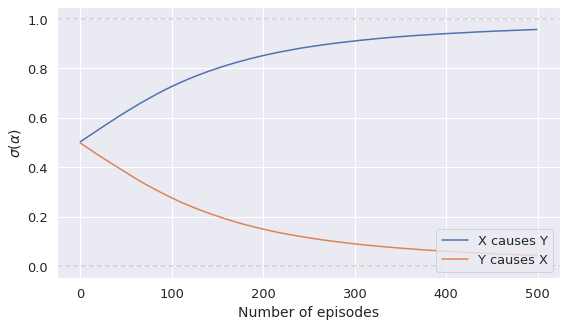

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
alpha_df.plot(ax = ax)

# ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\alpha)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})

plt.show()

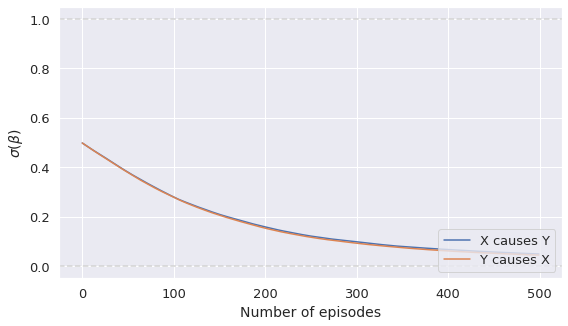

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
beta_df.plot(ax = ax)

# ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\beta)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})

plt.show()

In [ ]:
model_x2y = mdn(opt)
model_x2y_wGz = mdn_mu_sigma_w(opt)
model_x2y_zGw = mdn_mu_sigma_z(opt)

model_xGz = FCMMDN(opt.CAPACITY, 1)

frames_x2y = train_nll(opt, model_x2y, model_x2y_zGw, model_x2y_wGz, scm, opt.TRAIN_DISTRY, 
                       opt.BETA_05_DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='X2Y',
                        loss_fn=mdn_nll, decoder=None, encoder=None)

model_y2x = mdn(opt)
model_y2x_wGz = mdn_mu_sigma_w(opt)
model_y2x_zGw = mdn_mu_sigma_z(opt)
frames_y2x = train_nll(opt, model_y2x, model_y2x_zGw, model_y2x_wGz, scm, opt.TRAIN_DISTRY, 
                       opt.BETA_05_DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='Y2X',
                        loss_fn=mdn_nll, decoder=None, encoder=None)

model_xGz = mdn(opt)
model_yGz = mdn(opt)
model_zGw = mdn_mu_sigma_z(opt)
model_wGz = mdn_mu_sigma_z(opt)
margframs = train_marg(opt, model_xGz, model_yGz, model_zGw, model_wGz, scm, opt.TRAIN_DISTRY, opt.TRAIN_DISTRY, 
                       opt.BETA_05_DISTR_FOR_Z, opt.DISTR_FOR_W,
                        loss_fn=mdn_nll, decoder=None, encoder=None)

alpha = make_alpha(opt)
beta = make_alpha(opt)
alpha_frames = train_alpha(opt, model_x2y, model_y2x, model_xGz, model_yGz, model_x2y_zGw, model_x2y_wGz, 
                           model_y2x_zGw, model_y2x_wGz, model_zGw, model_wGz, alpha, beta, scm, 
                           opt.PARAM_DISTRY, opt.BETA_05_DISTR_FOR_Z, opt.DISTR_FOR_W, 
                           opt.PARAM_SAMPLER, mdn_nll,auc_transfer_metric, mixmode='logmix')

alpha05 = np.asarray([frame.sig_alpha for frame in alpha_frames])
beta05 = np.asarray([frame.sig_beta for frame in alpha_frames])


model_x2y = mdn(opt)
model_x2y_wGz = mdn_mu_sigma_w(opt)
model_x2y_zGw = mdn_mu_sigma_z(opt)

model_xGz = FCMMDN(opt.CAPACITY, 1)

frames_x2y = train_nll(opt, model_x2y, model_x2y_zGw, model_x2y_wGz, scm, opt.TRAIN_DISTRY, 
                       opt.BETA_2_DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='X2Y',
                        loss_fn=mdn_nll, decoder=None, encoder=None, ground_var = 'Y')

model_y2x = mdn(opt)
model_y2x_wGz = mdn_mu_sigma_w(opt)
model_y2x_zGw = mdn_mu_sigma_z(opt)
frames_y2x = train_nll(opt, model_y2x, model_y2x_zGw, model_y2x_wGz, scm, opt.TRAIN_DISTRY, 
                       opt.BETA_2_DISTR_FOR_Z, opt.DISTR_FOR_W, polarity='Y2X',
                        loss_fn=mdn_nll, decoder=None, encoder=None, ground_var = 'Y')

model_xGz = mdn(opt)
model_yGz = mdn(opt)
model_zGw = mdn_mu_sigma_z(opt)
model_wGz = mdn_mu_sigma_z(opt)
margframs = train_marg(opt, model_xGz, model_yGz, model_zGw, model_wGz, scm, opt.TRAIN_DISTRY, opt.TRAIN_DISTRY, 
                       opt.BETA_2_DISTR_FOR_Z, opt.DISTR_FOR_W,
                        loss_fn=mdn_nll, decoder=None, encoder=None, ground_var = 'Y')

alpha = make_alpha(opt)
beta = make_alpha(opt)
alpha_frames = train_alpha(opt, model_x2y, model_y2x, model_xGz, model_yGz, model_x2y_zGw, model_x2y_wGz, 
                           model_y2x_zGw, model_y2x_wGz, model_zGw, model_wGz, alpha, beta, scm, 
                           opt.PARAM_DISTRY, opt.BETA_2_DISTR_FOR_Z, opt.DISTR_FOR_W, 
                           opt.PARAM_SAMPLER, mdn_nll,auc_transfer_metric, mixmode='logmix', ground_var = 'Y')

alpha2 = np.asarray([frame.sig_alpha for frame in alpha_frames])
beta2 = np.asarray([frame.sig_beta for frame in alpha_frames])

import pandas as pd

alpha_df = pd.DataFrame({r'Beta, $\alpha=0.5$, $\beta=0.5$': alpha05, 
                         r'Beta, $\alpha=2$, $\beta=2$': alpha2})
beta_df = pd.DataFrame({r'Beta, $\alpha=0.5$, $\beta=0.5$': beta05, 
                         r'Beta, $\alpha=2$, $\beta=2$': beta2})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:388: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


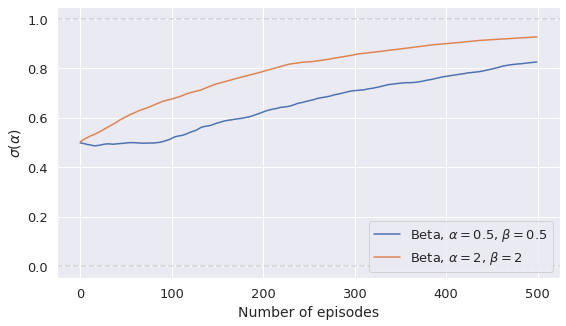

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
alpha_df.plot(ax = ax)

# ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\alpha)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})

plt.show()

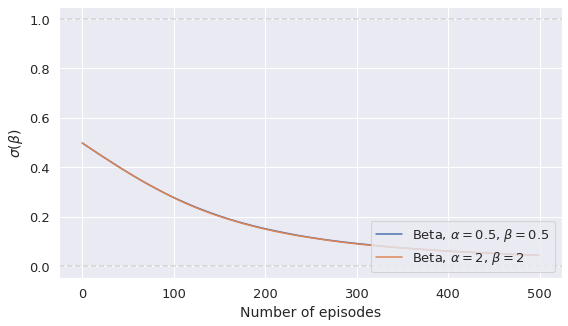

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')
beta_df.plot(ax = ax)

# ax.set_xlim([0, opt.ALPHA_NUM_ITER - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel(r'$\sigma(\beta)$', fontsize=14)
ax.legend(loc=4, prop={'size': 13})

plt.show()

# End